#  Quantum particle with dissipation (Usage of steadystate for a lattice model)

Saumya Biswas (saumyab@uoregon.edu)

On a lattice, we can track the time evolution of quantum states of microscopic phenomena as well as macroscopic problems.

## A wave propagation example

The continuum/scattering eigenstates of the Hamiltonian (also eigenstates of the crystal momentum operator) of a 1d lattice are complex plane waves. These plane waves are commensurate with the length of the lattice, i.e. the length of the crystal is an integer multiple of the wavelength of the plane wave. Scattering states carry a current and has a nonzero momentum. In a coherent dynamics example, they propagate energy/current in a direction. 

In [54]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np

In [55]:
gamma = 2
num_cell = 30
cell_num_site = 1
cell_site_dof = [2]
v0 = 1 
vm1 = 0.75 * v0 
Delta = 1

kpoints = 100
vpns = 126

Vb_A = np.zeros((vpns, 1), dtype=complex)
VbI_A = np.zeros((vpns, 1), dtype=complex)
Vb_ana_A = np.zeros((vpns, 1), dtype=complex)
VbL_A = np.zeros((vpns, 1), dtype=complex)
Vp1_Array = np.zeros((vpns, 1), dtype=float)
ck_ops = [np.sqrt(gamma) * destroy(2) ]

## With a lattice model

In [62]:
for j in range(vpns):
    vp1 = 0.01 * j
   
    Vp1_Array[j, 0] = vp1

    cell_H = Qobj(np.array([[0, v0], [v0, Delta]]))
#    inter_cell_T = Qobj(np.array([[0, vm1], [vp1, 0]]))
    inter_cell_T = Qobj(np.array([[0, vp1], [vm1, 0]]))   # For now

    disp_lat = Lattice1d(num_cell=num_cell, boundary = "periodic", cell_num_site = cell_num_site, cell_site_dof = cell_site_dof, Hamiltonian_of_cell = cell_H, inter_hop = inter_cell_T )
    xd = disp_lat.x()
    Hamt = disp_lat.Hamiltonian()    
    vel_op = -1j* (Hamt * xd - xd * Hamt)
    
    cl_ops = []
    B2A = destroy(2)
    #B2A = create(2)
    for i in range(num_cell):
        Lm = np.sqrt(gamma) * disp_lat.operator_at_cells(B2A, [i])
        cl_ops.append(Lm)

    lat_ss = steadystate(Hamt, cl_ops)

    VsL = (lat_ss * vel_op).tr()
    VbL_A[j, 0] = VsL


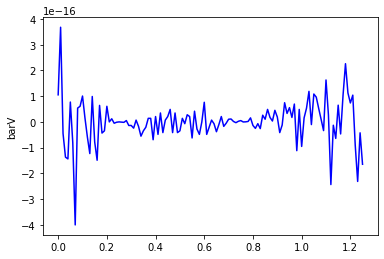

In [63]:
plt.plot(Vp1_Array , np.real(VbL_A),'b')
plt.ylabel('barV')
plt.show()
plt.close()

## Using steady state functions

In [64]:
for j in range(vpns):
    vp1 = 0.01 * j
    
    Vp1_Array[j, 0] = vp1

    cell_H = Qobj(np.array([[0, v0], [v0, Delta]]))
#    inter_cell_T = Qobj(np.array([[0, vm1], [vp1, 0]]))
    inter_cell_T = Qobj(np.array([[0, vp1], [vm1, 0]]))   # For now

    # print(cell_H)
    # print(inter_cell_T)

    disp_lat = Lattice1d(num_cell=num_cell, boundary = "periodic", cell_num_site = cell_num_site, cell_site_dof = cell_site_dof, Hamiltonian_of_cell = cell_H, inter_hop = inter_cell_T )

    (knxA, qH_ks, val_kns, vec_kns, vec_xs) = disp_lat._k_space_calculations(kpoints)
    
    dHdks = np.array([None for i in range(kpoints)])
    EH_ks = np.array([None for i in range(kpoints+1)])
    rhok_sss = np.array([None for i in range(kpoints)])
    for l in range(kpoints):
        EH_ks[l] = qH_ks[l]
    EH_ks[kpoints] = qH_ks[0]
    
    for l in range(kpoints):
#        print("l: ", l)
        dHdks[l] = EH_ks[l+1] - EH_ks[l]
    dHdks = (kpoints/2/np.pi) * dHdks

    t_trace = 0
    for k in range(kpoints):
        Hamt_k = qH_ks[k]
        kval = knxA[k]
        
        ck = v0 + vm1 * np.exp(-kval*1j) + vp1 * np.exp(kval*1j)
        Ham_k = Qobj(np.array([[Delta, ck], [np.conj(ck), 0]]))        
        
        rhok_ss = steadystate(Hamt_k, ck_ops)
        
        rh_ss_00 =  ck*np.conj(ck)+ (Delta **2 + (gamma/2)**2)
        rh_ss_01 = -ck * (Delta - 1j*gamma/2)
        rh_ss_10 = -np.conj(ck) * (Delta + 1j*gamma/2)
        rh_ss_11 =  ck*np.conj(ck)
        
        rh_ss = np.zeros((2, 2), dtype=complex)
        rh_ss[0, 0] = rh_ss_00
        rh_ss[0, 1] = rh_ss_01
        rh_ss[1, 0] = rh_ss_10
        rh_ss[1, 1] = rh_ss_11
#        rh_ss = np.array([[rh_ss_00, rh_ss_10], [rh_ss_01, rh_ss_11]])
        rh_ss = rh_ss / (2*ck*np.conj(ck)+ (Delta **2 + (gamma/2)**2))
        rh_ss = rh_ss / rh_ss[1, 1]
        rh_ss = Qobj(rh_ss)

        rhok_sss[k] = rhok_ss
        rhok_sss[k] = rh_ss        
        t_trace = t_trace + rhok_sss[k].tr()

    rhok_sss = rhok_sss / t_trace
    
    barV = np.zeros((1, kpoints), dtype=complex)
    barVI = np.zeros((1, kpoints), dtype=complex)



    sums = 0
    for i in range(100):
        k = 2*np.pi/100* i
        ck = v0 + vp1 * np.exp(k*1j) + vm1 * np.exp(-k*1j)
        sums = sums + 2 + (Delta ** 2 + (gamma/2) ** 2)/ ck /np.conj(ck)

    Z = sums

    for k in range(kpoints):
        dHdk = dHdks[k]

        kval = knxA[k]        

        ck = v0 + vp1 * np.exp(kval*1j) + vm1 * np.exp(-kval*1j)
#        dk = 1j * (vp1 * np.exp(kval*1j) - vm1 * np.exp(-kval*1j) )
        rhok_01 = (-Delta + 1j*gamma/2) / np.conj(ck)
        rhok_10 = (-Delta - 1j*gamma/2) / ck
        rhok_00 = (1 + rhok_01 * rhok_10)
        rhok_11 = 1
        rhok = np.array([[rhok_00, rhok_01], [rhok_10, rhok_11]],dtype=complex)
        rhok = rhok / Z
        rhok = Qobj(rhok)
        
        
        rhok_ss = rhok_sss[k]

        barV[0, k] = (dHdk * rhok_ss).tr()
        barVI[0, k] = (dHdk * rhok).tr()        
    Vb = np.sum(barV)    #sum over k
    VbI = np.sum(barVI)    #sum over k    
    Vb_A[j, 0] = Vb
    VbI_A[j, 0] = VbI 

/home/ssaumya7/anaconda_21/envs/serenity/lib/python3.6/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


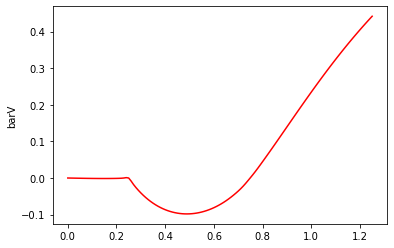

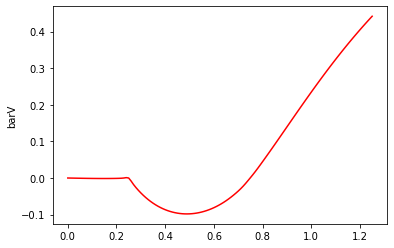

In [65]:
plt.plot(Vp1_Array , np.real(Vb_A),'r')
plt.ylabel('barV')
plt.show()
plt.close()

plt.plot( Vp1_Array , np.real(VbI_A),'r')
plt.ylabel('barV')
plt.show()
plt.close()

## Analytical Results

In [66]:
for j in range(126):
    vp1 = 0.01 * j
    Vp1_Array[j, 0] = vp1

    sums = 0
    for i in range(101):
        k = 2*np.pi/100* i
        ck = v0 + vp1 * np.exp(k*1j) + vm1 * np.exp(-k*1j)
        sums = sums + 2 + (Delta ** 2 + (gamma/2) ** 2)/ ck /np.conj(ck)

    Z = sums

    barV = np.zeros((1, 101), dtype=complex)
    kA = np.zeros((101, 1), dtype=complex)

    for i in range(101):
        k = 2*np.pi/100* i
        kA[i, 0] = k
        ck = v0 + vp1 * np.exp(k*1j) + vm1 * np.exp(-k*1j)
        dk = 1j * (vp1 * np.exp(k*1j) - vm1 * np.exp(-k*1j) )
        rhok_01 = (-Delta + 1j*gamma/2) / np.conj(ck)/Z
        rhok_10 = np.conj(rhok_01)/Z
        rhok_00 = (1 + rhok_01 * rhok_10)/Z
        rhok_11 = 1/Z
        rhok = np.array([[rhok_00, rhok_01], [rhok_10, rhok_11]],dtype=complex)
        rhok = Qobj(rhok)
    
        dHkdk = np.array([[0, dk], [np.conj(dk), 0]], dtype=complex)
        dHkdk = Qobj(dHkdk)
    
        v_t = dHkdk * rhok
        barV[0, i] = v_t.tr()    

    Vb = np.sum(barV)    #sum over k
    Vb_ana_A[j, 0] = Vb

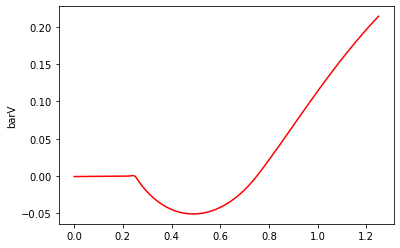

In [67]:
plt.plot( Vp1_Array , np.real(Vb_ana_A),'r')
plt.ylabel('barV')
plt.show()
plt.close()

### References

1. Kastoryano, Michael J., and Mark S. Rudner. "Topological transport in the steady state of a quantum particle with dissipation." Physical Review B 99.12 (2019): 125118. (https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.125118)

In [20]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, and Eric Giguère.
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.5.0.dev0+c8074e5
Numpy Version:      1.15.2
Scipy Version:      1.1.0
Cython Version:     0.28.5
Matplotlib Version: 3.0.0
Python Version:     3.5.4
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   True
INTEL MKL Ext:      True
Platform Info:      Linux (x86_64)
Installation path:  /home/ssaumya7/Desktop/GSOC/Aug5/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


In [21]:
qutip.cite()

@article{qutip2,
doi = {10.1016/j.cpc.2012.11.019},
url = {https://doi.org/10.1016/j.cpc.2012.11.019},
year  = {2013},
month = {apr},
publisher = {Elsevier {BV}},
volume = {184},
number = {4},
pages = {1234--1240},
author = {J.R. Johansson and P.D. Nation and F. Nori},
title = {{QuTiP} 2: A {P}ython framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}
@article{qutip1,
doi = {10.1016/j.cpc.2012.02.021},
url = {https://doi.org/10.1016/j.cpc.2012.02.021},
year  = {2012},
month = {aug},
publisher = {Elsevier {BV}},
volume = {183},
number = {8},
pages = {1760--1772},
author = {J.R. Johansson and P.D. Nation and F. Nori},
title = {{QuTiP}: An open-source {P}ython framework for the dynamics of open quantum systems},
journal = {Computer Physics Communications}
}
